## AMAZON Food Reviews Analysis
LSTM Model for Food Reviews
Adam Goldstein

In [26]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import preprocessing
from sklearn.metrics import mean_squared_error
import string
import re
import nltk
from nltk.stem.porter import PorterStemmer

In [27]:
data = pd.read_csv('data/Reviews.csv')

# Convert pickle to panda dataframe
#data = pd.read_csv('Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Preprocessing

In [28]:
data = data[['Text', 'Score']]
data['review'] = data['Text']
data['label'] = data['Score']
data.drop(['Text', 'Score'], axis=1, inplace=True)

# Drop neutral reviews
data = data[data['label'] != 3]

# Make ratings either 1 or 0
data['label'] = data['label'].apply(lambda x: 1 if x > 3 else 0)

# Drop duplicates
data = data.drop_duplicates()

### I am going to perform initial training on subset of data but I will use the full dataset for final evaluation.

## Balance the data


In [29]:
# Balance the data set
positives = data[data['label'] == 1][:len(data[data['label'] == 0])]
data = pd.concat([data, positives])


In [30]:
print(data.shape)
print(data.head())

(420914, 2)
                                              review  label
0  I have bought several of the Vitality canned d...      1
1  Product arrived labeled as Jumbo Salted Peanut...      0
2  This is a confection that has been around a fe...      1
3  If you are looking for the secret ingredient i...      0
4  Great taffy at a great price.  There was a wid...      1


In [31]:
# Count positive and negative reviews
print(data['label'].value_counts())

1    363841
0     57073
Name: label, dtype: int64


In [32]:
# Get 20000 positive reviews and 20000 negative reviews
data = data.sample(frac=1)
data_pos = data[data['label'] == 1][:20000]
data_neg = data[data['label'] == 0][:20000]
df = pd.concat([data_pos, data_neg])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,review,label
0,I bought a gallon of this and when it came it ...,0
1,I was excited to purchase this given popcorn's...,0
2,"The four jams come tucked in a simple, white, ...",1
3,"I'm so happy Amazon got this in again, finally...",1
4,"I opened the box carefully, but I found all br...",0


In [33]:
# Count number of posotive and negative reviews
print(df['label'].value_counts())

0    20000
1    20000
Name: label, dtype: int64


# **NLP word processing**
(These take a while to run, especially stemming)

In [34]:
df['review'] = df['review'].apply(str) #some reviews are floats for some reason

In [35]:
#make lowercase
df['review'] = df['review'].apply(lambda x: x.lower())

In [36]:
#remove punctuation
df['review'] = df['review'].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))

In [37]:
# remove numbers
df['review'] = df['review'].apply(lambda x: re.sub(r'\d+', '', x))

In [38]:
# remove whitespace
df['review'] = df['review'].apply(lambda x: x.strip())

In [39]:
df.head()

,review,label
0,i bought a gallon of this and when it came it ...,0
1,i was excited to purchase this given popcorns ...,0
2,the four jams come tucked in a simple white sq...,1
3,im so happy amazon got this in again finally c...,1
4,i opened the box carefully but i found all bro...,0


# Prepare for training

In [41]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

In [42]:
# Tokenize words
tokenizer = preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [43]:
# transform xtrain and xtest
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## Padding the data

In [44]:
vocab_size = len(tokenizer.word_index) + 1
max_review_len = 150

X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_review_len)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_review_len)

# Build the Model

## Model 1 LSTM

In [46]:
# Build model
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 32))
model.add(layers.LSTM(100))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          1643552   
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,696,853
Trainable params: 1,696,853
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
1000/1000 [==============================] - 45s 44ms/step - loss: 0.3775 - accuracy: 0.8308 - val_loss: 0.3357 - val_accuracy: 0.8643
Epoch 2/10
1000/1000 [==============================] - 44s 44ms/step - loss: 0.2444 - accuracy: 0.9057 - val_loss: 0.3235 - val_accuracy: 0.8670
Epoch 3/10
1000/1000 [==============================] - 42s 42ms/step - loss: 0.1935 - accuracy: 0.9286 - val_loss: 0.3152 - val_accuracy: 0.8752
Epoch 4/10
1000/1000 [==============================] - 44s 44ms/step - loss: 0.1510 - accuracy: 0.9448 - val_loss: 0.3524 - val_accuracy: 0.8785
Epoch 5/10
1000/1000 [==============================] - 44s 44ms/step - loss: 0.1200 - accuracy: 0.9572 - val_loss: 0.3748 - val_accuracy: 0.8783
Epoch 6/10
1000/1000 [==============================] - 46s 46ms/step - loss: 0.1176 - accuracy: 0.9598 - val_loss: 0.3647 - val_accuracy: 0.8736
Epoch 7/10
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0766 - accuracy: 0.9745 - val_loss: 0.4247 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


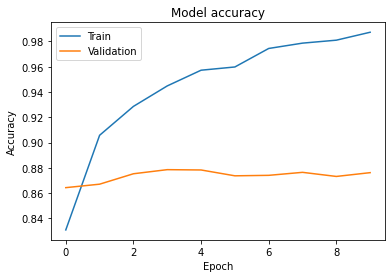

In [49]:
# Plot training & validation accuracy values
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

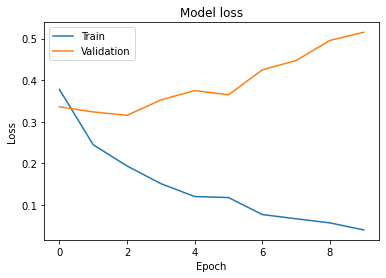

In [50]:
# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [53]:
# Predict on test data
predictions = model.predict(X_test)
predictions = (predictions > 0.5)
print(predictions)

# Make a fake review to predict on
fake_review_bad = "The food was terrible, and I will not be buying it again"
fake_review_bad = [fake_review_bad]
fake_review_bad = tokenizer.texts_to_sequences(fake_review_bad)
fake_review_bad = preprocessing.sequence.pad_sequences(fake_review_bad, maxlen=max_review_len)

predict_bad = model.predict(fake_review_bad)
print(predict_bad)

fake_review_good = "The food was amazing, and I will be buying it again"
fake_review_good = [fake_review_good]
fake_review_good = tokenizer.texts_to_sequences(fake_review_good)
fake_review_good = preprocessing.sequence.pad_sequences(fake_review_good, maxlen=max_review_len)

predict_good = model.predict(fake_review_good)
print(predict_good)

[[False]
 [ True]
 [ True]
 ...
 [False]
 [False]
 [ True]]
[[0.00015631]]
[[0.99355304]]
